## Dataset Loading
This section imports the required libraries and loads the dataset into a pandas DataFrame. The dataset is the foundation for all subsequent preprocessing and analysis steps. we will install all the librabies that we need.

In [1]:
## pip install statsmodels pandas matplotlib seaborn

## 1️⃣ Loading & Saving Data

### `pd.read_csv()` — Load data
Reads a CSV file into a DataFrame.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



df = pd.read_csv("./ElectronicsProductsPricingData.csv", encoding='latin1')



df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7249 entries, 0 to 7248
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   7249 non-null   object 
 1   prices.amountMax     7249 non-null   float64
 2   prices.amountMin     7249 non-null   float64
 3   prices.availability  7249 non-null   object 
 4   prices.condition     7249 non-null   object 
 5   prices.currency      7249 non-null   object 
 6   prices.dateSeen      7249 non-null   object 
 7   prices.isSale        7249 non-null   bool   
 8   prices.merchant      7249 non-null   object 
 9   prices.shipping      4277 non-null   object 
 10  prices.sourceURLs    7249 non-null   object 
 11  asins                7249 non-null   object 
 12  brand                7249 non-null   object 
 13  categories           7249 non-null   object 
 14  dateAdded            7249 non-null   object 
 15  dateUpdated          7249 non-null   o

In [3]:
## removving all the unnecessary columns from the dataframe
df.drop(columns=["Unnamed: 26","Unnamed: 27","Unnamed: 28","Unnamed: 29","Unnamed: 30","sourceURLs","prices.currency", "keys","ean","prices.shipping","manufacturerNumber","upc"], inplace=True)
df.head()

,id,prices.amountMax,prices.amountMin,prices.availability,prices.condition,prices.dateSeen,prices.isSale,prices.merchant,prices.sourceURLs,asins,brand,categories,dateAdded,dateUpdated,imageURLs,manufacturer,name,primaryCategories,weight
0,AVphzgbJLJeJML43fA0o,104.99,104.99,Yes,New,"2017-03-30T06:00:00Z,2017-03-10T22:00:00Z,2017...",False,Bestbuy.com,http://www.bestbuy.com/site/sanus-tv-wall-moun...,B00C78VIUE,Sanus,"Audio & Video Accessories,TV Mounts,TV Accesso...",2015-04-13T12:00:51Z,2018-05-12T18:59:48Z,https://images-na.ssl-images-amazon.com/images...,NaN,Sanus VLF410B1 10-Inch Super Slim Full-Motion ...,Electronics,32.8 pounds
1,AVpgMuGwLJeJML43KY_c,69.00,64.99,In Stock,New,2017-12-14T06:00:00Z,True,Walmart.com,https://www.walmart.com/ip/BOYTONE-BT210FB-BLA...,"B018K251JE,B00VILQKQ8",Boytone,"Stereos,Portable Bluetooth Speakers,TV, Video ...",2015-05-18T14:14:56Z,2018-06-13T19:39:02Z,https://images-na.ssl-images-amazon.com/images...,Boytone,Boytone - 2500W 2.1-Ch. Home Theater System - ...,Electronics,14 pounds
2,AVpgMuGwLJeJML43KY_c,69.00,69.00,In Stock,New,2017-09-08T05:00:00Z,False,Walmart.com,https://www.walmart.com/ip/Boytone-BT-210F-Blu...,"B018K251JE,B00VILQKQ8",Boytone,"Stereos,Portable Bluetooth Speakers,TV, Video ...",2015-05-18T14:14:56Z,2018-06-13T19:39:02Z,https://images-na.ssl-images-amazon.com/images...,Boytone,Boytone - 2500W 2.1-Ch. Home Theater System - ...,Electronics,14 pounds
3,AVpgMuGwLJeJML43KY_c,69.99,69.99,Yes,New,2017-10-10T05:00:00Z,False,Bestbuy.com,https://www.bestbuy.com/site/boytone-2500w-2-1...,"B018K251JE,B00VILQKQ8",Boytone,"Stereos,Portable Bluetooth Speakers,TV, Video ...",2015-05-18T14:14:56Z,2018-06-13T19:39:02Z,https://images-na.ssl-images-amazon.com/images...,Boytone,Boytone - 2500W 2.1-Ch. Home Theater System - ...,Electronics,14 pounds
4,AVpgMuGwLJeJML43KY_c,66.99,66.99,Yes,New,2017-08-28T07:00:00Z,False,Bestbuy.com,https://www.bestbuy.com/site/boytone-2500w-2-1...,"B018K251JE,B00VILQKQ8",Boytone,"Stereos,Portable Bluetooth Speakers,TV, Video ...",2015-05-18T14:14:56Z,2018-06-13T19:39:02Z,https://images-na.ssl-images-amazon.com/images...,Boytone,Boytone - 2500W 2.1-Ch. Home Theater System - ...,Electronics,14 pounds


In [4]:

##1.2 we will check if the prices amountMax and minAmount is same 

df.dropna(subset=["prices.amountMax", "prices.amountMin"], inplace=True)
df["price_difference"] = df["prices.amountMax"] - df["prices.amountMin"]
df.info()

## 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7249 entries, 0 to 7248
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   7249 non-null   object 
 1   prices.amountMax     7249 non-null   float64
 2   prices.amountMin     7249 non-null   float64
 3   prices.availability  7249 non-null   object 
 4   prices.condition     7249 non-null   object 
 5   prices.dateSeen      7249 non-null   object 
 6   prices.isSale        7249 non-null   bool   
 7   prices.merchant      7249 non-null   object 
 8   prices.sourceURLs    7249 non-null   object 
 9   asins                7249 non-null   object 
 10  brand                7249 non-null   object 
 11  categories           7249 non-null   object 
 12  dateAdded            7249 non-null   object 
 13  dateUpdated          7249 non-null   object 
 14  imageURLs            7249 non-null   object 
 15  manufacturer         3235 non-null   o

In [5]:
## we will check if the data has unique ids 
df["id"].value_counts()

id
AV1YFZVDvKc47QAVgp7V    59
AVs4jJ0Vnnc1JgDc4w40    53
AVrI3KE1U2_QcyX9O9Iw    52
AVzxqGmivKc47QAVfTIA    45
AVqkH8TtU2_QcyX9O0rJ    45
                        ..
AWBghGZdYSSHbkXws4Zi     1
AVpfM3TL1cnluZ0-gDuQ     1
AVpiMIyE1cnluZ0-K0TA     1
AV7tZTTYYSSHbkXwokf2     1
AVphzgbJLJeJML43fA0o     1
Name: count, Length: 835, dtype: int64

In [6]:
## checking in the dataframe electronics if there are different products
## from the above category , we have check if the dataframe have different id, and then check how many values does each id has , where we found one particular interested one. 


df_id = df[df["id"] == "AV1YFZVDvKc47QAVgp7V"]
df_id = df_id[df_id["prices.isSale"] == True]
df_id.head()

,id,prices.amountMax,prices.amountMin,prices.availability,prices.condition,prices.dateSeen,prices.isSale,prices.merchant,prices.sourceURLs,asins,brand,categories,dateAdded,dateUpdated,imageURLs,manufacturer,name,primaryCategories,weight,price_difference
3722,AV1YFZVDvKc47QAVgp7V,125.99,125.99,TRUE,new,2018-05-27T08:00:00Z,True,Bestbuy.com,https://www.bestbuy.com/site/wd-red-4tb-intern...,"B00EHBERSE,B00F0EIKJO",WD,"Computers,Internal Hard Drives,Network Attache...",2017-07-18T23:43:15Z,2018-06-16T02:07:00Z,http://i.ebayimg.com/thumbs/images/g/a6gAAOSwX...,NaN,"4TB Network OEM HDD Retail Kit (8-Pack, WD40EF...",Electronics,22.9 ounces,0.00
3750,AV1YFZVDvKc47QAVgp7V,154.99,139.87,In Stock,New,2018-01-18T14:00:00Z,True,Beach Audio Inc,https://www.walmart.com/ip/Western-Digital-WD4...,"B00EHBERSE,B00F0EIKJO",WD,"Computers,Internal Hard Drives,Network Attache...",2017-07-18T23:43:15Z,2018-06-16T02:07:00Z,http://i.ebayimg.com/thumbs/images/g/a6gAAOSwX...,NaN,"4TB Network OEM HDD Retail Kit (8-Pack, WD40EF...",Electronics,22.9 ounces,15.12
3755,AV1YFZVDvKc47QAVgp7V,148.59,133.99,In Stock,New,2018-01-10T10:00:00Z,True,Walmart.com,https://www.walmart.com/ip/WD-Red-4TB-NAS-Hard...,"B00EHBERSE,B00F0EIKJO",WD,"Computers,Internal Hard Drives,Network Attache...",2017-07-18T23:43:15Z,2018-06-16T02:07:00Z,http://i.ebayimg.com/thumbs/images/g/a6gAAOSwX...,NaN,"4TB Network OEM HDD Retail Kit (8-Pack, WD40EF...",Electronics,22.9 ounces,14.60
3761,AV1YFZVDvKc47QAVgp7V,148.59,140.45,In Stock,New,2017-10-24T23:00:00Z,True,Walmart.com,https://www.walmart.com/ip/4TB-WD-RED-SATA-6GB...,"B00EHBERSE,B00F0EIKJO",WD,"Computers,Internal Hard Drives,Network Attache...",2017-07-18T23:43:15Z,2018-06-16T02:07:00Z,http://i.ebayimg.com/thumbs/images/g/a6gAAOSwX...,NaN,"4TB Network OEM HDD Retail Kit (8-Pack, WD40EF...",Electronics,22.9 ounces,8.14


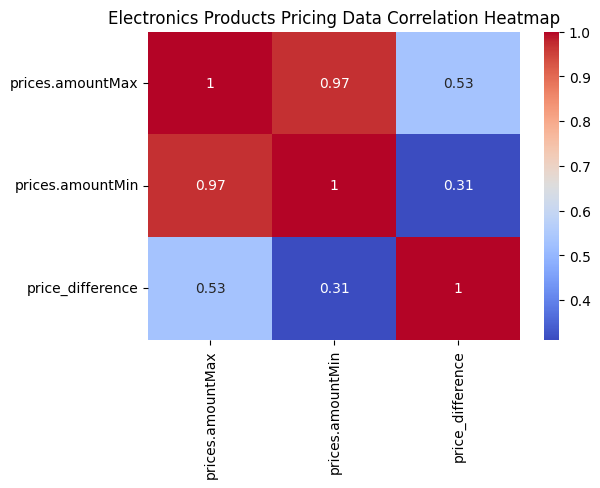

In [7]:
## we will us the heatmap for both the datasets to visualize the correlation between different numerical features
## For that we will use seaborn library
## Also we will filter out the non numerical columns from both the datasets


df_heat = df.select_dtypes(include=['float64', 'int64'])





## Electronics Products Pricing Data heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df_heat.corr(), annot=True, cmap="coolwarm")
plt.title("Electronics Products Pricing Data Correlation Heatmap")
plt.show()


## DATA Visuilatization 

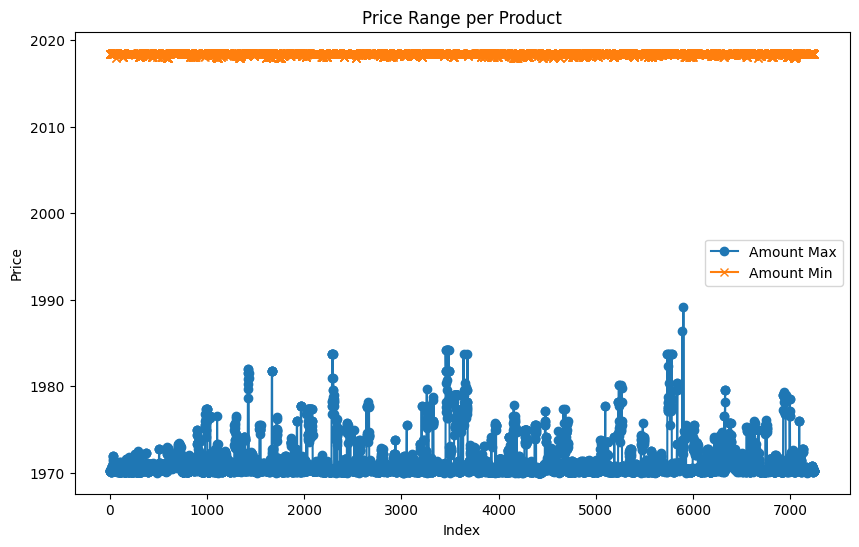

In [8]:
## We will use the scatterplot to check the price range per product

plt.figure(figsize=(10, 6))
df["dateUpdated"] = pd.to_datetime(df["dateUpdated"], errors='coerce')
plt.plot(
    df.index,
    df["prices.amountMax"],
    marker="o",
    label="Amount Max"
)

plt.plot(
    df.index,
    df["dateUpdated"],
    marker="x",
    label="Amount Min"
)

plt.xlabel("Index")
plt.ylabel("Price")
plt.title("Price Range per Product")
plt.legend()
plt.show()


In [9]:
### Seasonlality Analysis

## 1. We will check the seasonality of the products in the dataset by analyzing the prices over time.
df["prices.dateSeen"] = pd.to_datetime(df["prices.dateSeen"], errors="coerce")
df["discount_percent"] = ((df["prices.amountMax"] - df["prices.amountMin"]) / df["prices.amountMax"]) * 100




/var/folders/st/r78_rxtx0hd_yr_r8qtl08_c0000gn/T/ipykernel_98854/2157317505.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["prices.dateSeen"] = pd.to_datetime(df["prices.dateSeen"], errors="coerce")


In [10]:
## converting the date columns(which are in strings) to datetime format
df["date"] = pd.to_datetime(df["prices.dateSeen"], errors="coerce")
df["dateUpdated"] = pd.to_datetime(df["dateUpdated"], errors="coerce")
df["dateAdded"] = pd.to_datetime(df["dateAdded"], errors="coerce")

## extracting the year from the date column
df["date_year"] = df["prices.dateSeen"].dt.year
df["updated_year"] = df["dateUpdated"].dt.year
df["added_year"] = df["dateAdded"].dt.year

df["date_year"].value_counts()


date_year
2017.0    2250
2018.0    1354
2015.0      59
2014.0      11
Name: count, dtype: int64

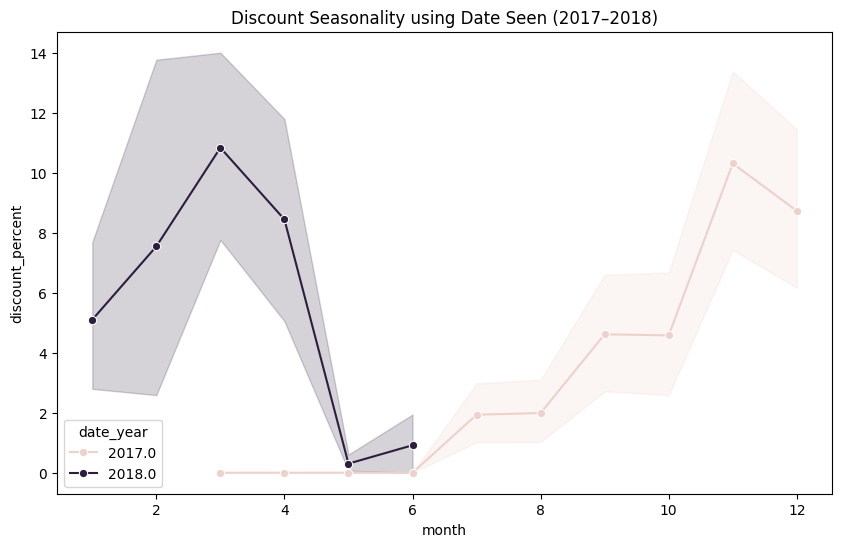

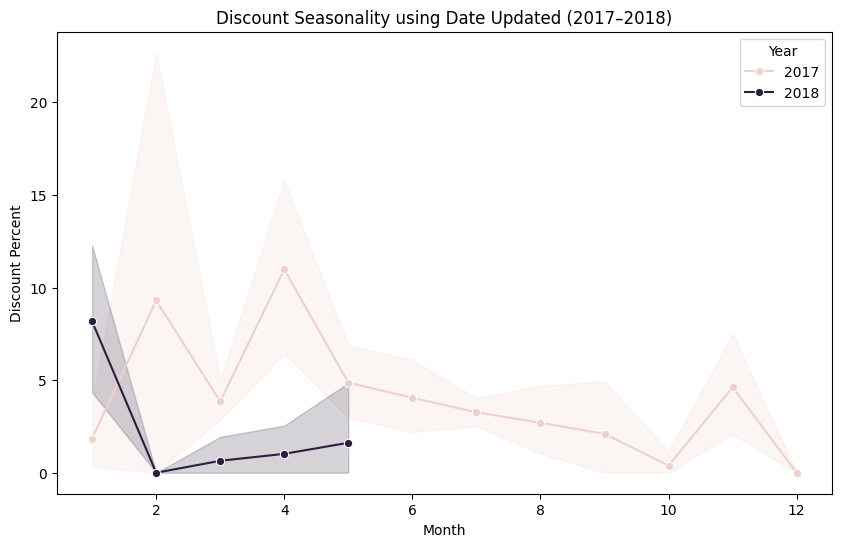

In [11]:
# we will remove the the year 2014 and 2015 from the dataset as they have very less data points and we will focus on the years 2017 and 2018 for our seasonality analysis.


## here we will change the data from the electronics dataset to only include the years 2017 and 2018 for the date seen, date updated and date added columns as they have more data points and we will focus on these years for our seasonality analysis.
df = df[df["updated_year"].isin([2017, 2018])]
df = df[df["date_year"].isin([2017, 2018])]
df = df[df["added_year"].isin([2017, 2018])]

df["month"] = df["date"].dt.month
plt.figure(figsize=(10, 6))

sns.lineplot(data=df, x="month", y="discount_percent", hue="date_year", marker="o")
plt.title("Discount Seasonality using Date Seen (2017–2018)")
plt.show()


##
df_added = df.copy()
df_added["month"] = df_added["dateAdded"].dt.month

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_added,
    x="month",
    y="discount_percent",
    hue="added_year",
    marker="o"
)

plt.title("Discount Seasonality using Date Updated (2017–2018)")
plt.xlabel("Month")
plt.ylabel("Discount Percent")
plt.legend(title="Year")
plt.show()






In [18]:
##df = df.set_index("prices.dateSeen").sort_index()

## if You got this error "None of ['prices.dateSeen'] are in the columns"
## then uncomment the above line 
plt.figure(figsize=(12, 6))
df_pivot_table = df.pivot_table(values="discount_percent", index=df.index.month, columns=df.index.year, aggfunc="mean")
print(df_pivot_table)

KeyError: "None of ['prices.dateSeen'] are in the columns"

<Axes: xlabel='prices.dateSeen', ylabel='prices.dateSeen'>

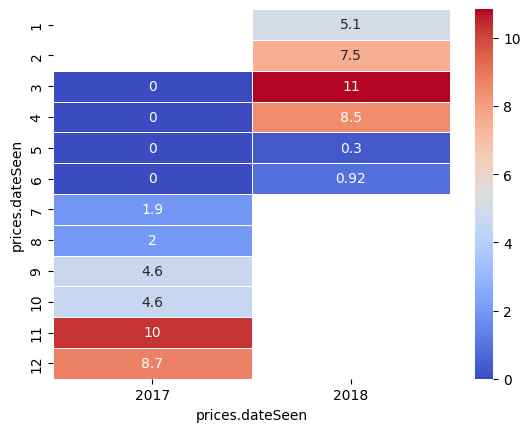

In [19]:

sns.heatmap(df_pivot_table, annot=True, cmap="coolwarm", linewidths=0.5)

# Rolling statics


In [ ]:
weekly_discount_size_seen = df.resample("W", on="date")["discount_percent"].mean()
weekly_discount_size_updated = df.resample("W", on="dateUpdated")["discount_percent"].mean()
weekly_discount_size_added = df.resample("W", on="dateAdded")["discount_percent"].mean()

weekly_discount_size_added.head()
plt.figure(figsize=(12, 6), )

sns.lineplot(data=weekly_discount_size_seen, label="Date Seen", marker="o")
sns.lineplot(data=weekly_discount_size_updated, label="Date Updated", marker="o")
sns.lineplot(data=weekly_discount_size_added, label="Date Added", marker="o")
plt.title("Weekly Average Discount Percent (2017–2018)")

## lag features 


In [ ]:
ts = (df.set_index("date").resample("W")["discount_percent"].mean()).dropna()
lag_df = pd.DataFrame({"current": ts})

lag_df["lag_1"] = ts.shift(1)
lag_df["lag_3"] = ts.shift(3)
lag_df["lag_6"] = ts.shift(6)
lag_df["lag_12"] = ts.shift(12)
 

In [120]:
lag_df = lag_df.dropna()

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(lag_df["lag_1"], lag_df["current"])
plt.xlabel("Lag 1 (t-1)")
plt.ylabel("Current (t)")
plt.title("Lag-1 Relationship")
plt.show()
